# F16 Low Level Controller analysis

In this example, we will show how to analyze a low-level-controller.

First, we need to import our model

In [1]:
from csaf_f16 import F16Simple
import csaf_f16.components as f16c
import csaf.utils as csafutils

We will create a model derived from the `F16Simple` system in `csaf_f16`, which replaces the autopilot with a signal generator of our own making.

In [2]:
def step_signal(model, time, _s, _i):
    """signal generator function steps the first llc input signal"""
    signal = [0.0,]*4
    if time >= model.step_time:
        signal[model.idx] = model.signal_amplitude
    return signal
        

class F16LlcSignal(f16c.F16AutopilotComponent):
    """create a CSAF component that uses the right message format
    for the f16 models"""
    name = "Signal Generator"
    default_parameters = {
        "signal_amplitude": 1.0, 
        "step_time": 1.0,
        "idx": 0
    }
    states = f16c.EmptyMessage
    default_initial_values = {
        "states" : [],
        "inputs_pstates": f16c.f16_xequil,
        "inputs_poutputs": [0.0, 0.0, 0.0, 0.0],
    }
    outputs = (
        ("outputs", f16c.F16ControllerOutputMessage),
    )
    flows = {
        "outputs": step_signal,
    }
    
    
class F16LlcDut(F16Simple):
    """create a F16 system that uses the signal generator"""
    components = {**F16Simple.components, 
                  **{"autopilot" : F16LlcSignal}}

We will also display the system topology, to show the difference between f16-simple and this system:

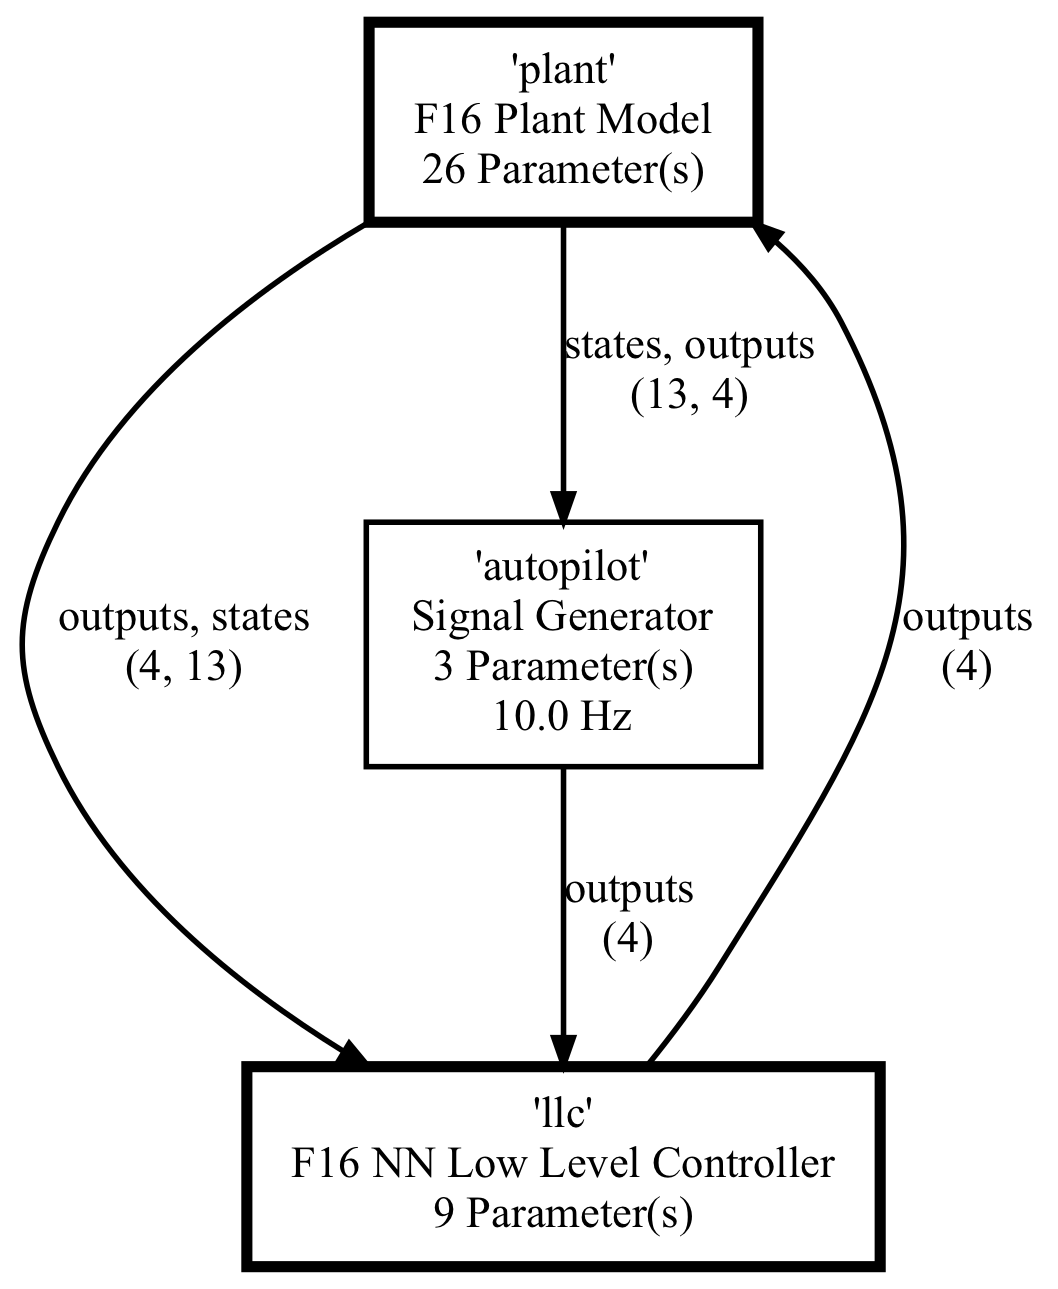

In [3]:
# visualize the system
csafutils.view_block_diagram(F16LlcDut, ipython_notebook=True)

Next step, we need to prepare initial conditions for our run. For this particular case, we will change only two variables at a time, so we can display the results in a 2D plot. However, you can generate the initial conditions in many different ways.

In [4]:
# We want to see step response to Nz (z-body accel)
# Varying airspeed and alpha is a good start
initial = [ 540.0, # vt
            0.037027160081059704, # alpha [rad]
            0.0, # beta[rad]
            0.0, # roll [rad]
            0.0, # pitch [rad]
            0.0, # yaw [rad]
            0.0, # p [rad/s]
            0.0, # q [rad/s]
            0.0, # r [rad/s]
            0.0, # pn [m]
            0.0, # pe [e]
            4800.0, # h [ft]
            70.0] # pow

import numpy as np

NUM_SAMPLES=10
delta_vt = np.linspace(-100,100,NUM_SAMPLES) # +- 100gt/s
delta_alpha = np.linspace(-0.3,0.3,NUM_SAMPLES) # +- 0.3rad

# Generate x0s
x0s = []
for d_vt in delta_vt:
    for d_alpha in delta_alpha:
        x0 = initial[:]
        x0[0] += d_vt
        x0[1] += d_alpha
        x0s.append(x0)

Now, we have 100 different initial conditions. Let's use our parallel runner to efficiently run 100 simulations!

In [5]:
from joblib import Parallel, delayed
import tqdm


def run_sim(x0):
    sys = F16LlcDut()
    sys.set_state('plant', x0)
    trajs = sys.simulate_tspan(tspan=(0.0, 10.0),  show_status=False)
    return trajs
    

runs = Parallel(n_jobs=12)(delayed(run_sim)(x0) for x0 in tqdm.tqdm(x0s))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.54it/s]


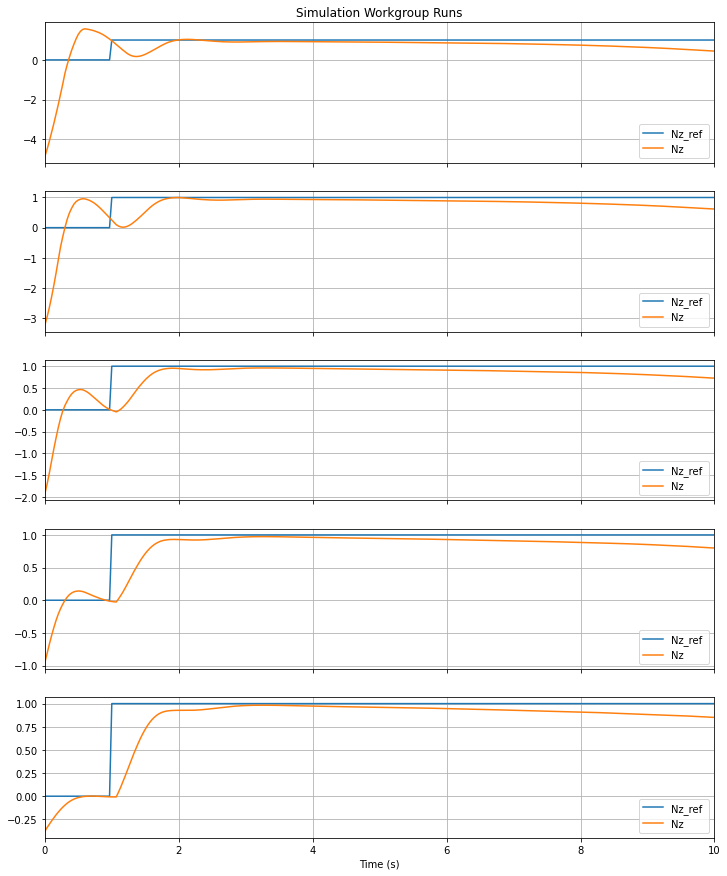

In [6]:
# Lets plot the results (this might take a while)
import matplotlib.pyplot as plt
from csaf_f16.plot import plot_component

nplots = 5
fig, ax = plt.subplots(figsize=(12, 3 * nplots), nrows=nplots, sharex=True)
for idx, (axis, run) in enumerate(zip(ax, runs)):
    if idx >= nplots:
        break
    trajs = run
    plot_component(axis, trajs, "autopilot", "outputs", 0, "Nz_ref ()")
    plot_component(axis, trajs, "plant", "outputs", 0, "Nz ()")

ax[-1].set_xlabel("Time (s)")
ax[0].set_title("Simulation Workgroup Runs")
plt.show()

We can inspect all 100 runs and see how closely the reference was followed. Given the relatively large range of initial conditions, some runs provide a very clean response, while some show large initial Nzand large overshoot.

You can modify the initial conditions, as well as the time and amplitude of the step signal to get more meaningful results.

The next question is - can we automatically evaluate the simulation results? The answer is yes!

## More automated analysis

First, define a function that returns the max difference between the reference signal and the response. Note that this is a very simple function meant only as an example. To gain better insight into your system, you should define a more complex function.

In [7]:
from numpy import nan

def calculate_simple_difference(ref_time, reference, res_time, response):
    # If either of the arguments is nan, return nan
    if ref_time is nan or reference is nan or res_time is nan or response is nan:
        return nan
    # Otherwise, assume both arguments are lists
    # Cut off first 1 second of simulation, because that is before the step occured
    start_time = 1.0
    _, ref_idx = min((val, idx) for (idx, val) in enumerate(ref_time) if val > start_time)
    _, res_idx = min((val, idx) for (idx, val) in enumerate(res_time) if val > start_time)
    ref = reference[ref_idx:]
    res = response[res_idx:]
    return max(res) - max(ref)

In [8]:
# Now calculate the difference for each simulation run
diffs = []
for trajs in runs:
    t_ref = trajs['autopilot'].times
    t = trajs['plant'].times
    nz = np.array(getattr(trajs['plant'], 'outputs'))[:, 0]
    nz_ref = np.array(getattr(trajs['autopilot'], 'outputs'))[:, 0]
    delta = calculate_simple_difference(t_ref, nz_ref, t, nz)
    diffs.append(delta)

In [9]:
# Max "overshoot"
val, idx = max((val, idx) for (idx, val) in enumerate(diffs))
print(f"Max 'overshoot' occured at run {idx}, over {val*100:1.2f} [%]")

Max 'overshoot' occured at run 99, over 15.47 [%]


In [10]:
# Min "overshoot"
val, idx = min((val, idx) for (idx, val) in enumerate(diffs))
print(f"Min 'overshoot' occured at run {idx}, over {val*100:1.2f} [%]")

Min 'overshoot' occured at run 2, over -3.99 [%]


This seem to indicate that the extreme initial conditions affect the response, which is expected. Lets now plot the results.

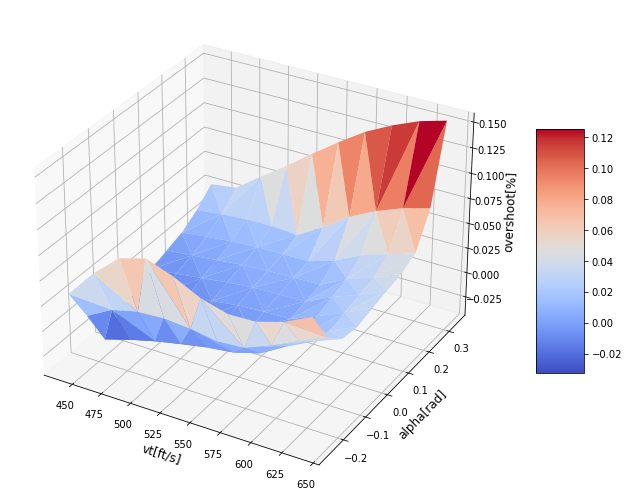

In [11]:
# Import libraries 
from mpl_toolkits import mplot3d 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import cm

x = []
y = []
z = diffs
for states in x0s:
    x.append(states[0])
    y.append(states[1])

fig = plt.figure(figsize =(14, 9)) 
ax = plt.axes(projection ='3d') 

ax.set_xlabel('vt[ft/s]', fontsize=12)
ax.set_ylabel('alpha[rad]', fontsize=12)
ax.set_zlabel('overshoot[%]', fontsize=12)
ax.xaxis.set_rotate_label(True)
ax.yaxis.set_rotate_label(True)

surf = ax.plot_trisurf(x, y, z, cmap=cm.coolwarm)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

# Rotate it
#ax.view_init(30, 135)

# show plot 
plt.show()

We can see that higher overshoot corresponds to higher alpha, and in lesser extend to higher airspeed.

Finally, if we are only interested in how many simulations do not exceed 10% overshoot, we can simply do:

In [12]:
len([x for x in diffs if x < 0.1])

95

## Summary
We demonstrated how to run multiple simulations in parallel, with different initail conditions, and how to analyzer the results. The analysis can be tailer to your needs.